# Mask a GeoTIFF with a Polygon

This notebook will demonstrate masking a GeoTIFF with a shapefile, returning a new GeoTIFF comprised of the original data where the shapefile overlapped / intersected those pixels, and nodata where it did not.

Here is the GeoTIFF we will use:

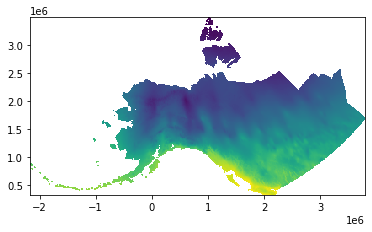

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 398, 'height': 211, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(15000.0, 0.0, -2168722.7210629326,
       0.0, -15000.0, 3491266.340399999)}


In [1]:
import rasterio as rio
from rasterio.plot import show


src_fp = "data/tas_mean_C_ar5_5ModelAvg_rcp85_01_2006.tif"
with rio.open(src_fp) as src:
    show(src, interpolation="none")
    print(src.meta)

And we will use the ["Alaska Coast Simplified" shapefile from the ua-snap/geospatial-vector-veracity repo](https://github.com/ua-snap/geospatial-vector-veracity/blob/600edb9c24a0000e67ff19b439458f25a2a07863/vector_data/polygon/boundaries/alaska_coast_simplified/Alaska_Coast_Simplified_Polygon.shp):

Shapefile CRS: PROJCS["Alaska_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Shapefile EPSG: 3338


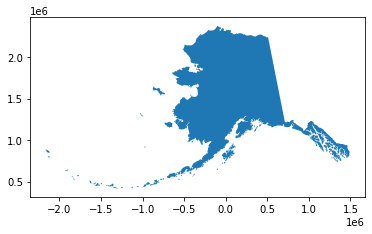

In [2]:
import geopandas as gpd


gdf = gpd.read_file("ancillary/shp/Alaska_Coast_Simplified_Polygon.shp")
gdf.plot()
print("Shapefile CRS:", gdf.crs)
print("Shapefile EPSG:", gdf.crs.to_epsg())

Note, both files already have the same CRS!

#### Mask the raster using `rasterio.mask.mask`:

Supply the DatasetReader object, the list of geometries in the GeoDataFrame, and the `crop=True` arguement, which will crop the original GeoTIFF to the extent of the shapefile:

In [3]:
from rasterio.mask import mask


with rio.open(src_fp) as src:
    new_arr, out_transform = mask(src, gdf.geometry, crop=True)
    new_meta = src.profile.copy()

This returns the new array from the GeoTIFF, that has been masked and cropped, along with the new transform computed from cropping the original. Here is the new array:

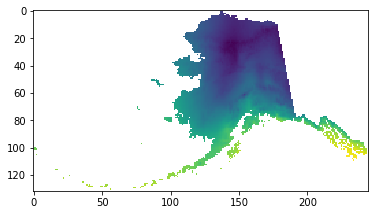

In [4]:
import matplotlib.pyplot as plt
import numpy as np


# temp array with nans for plotting purposes
tmp_arr = new_arr[0].copy()
tmp_arr[tmp_arr == src.meta["nodata"]] = np.nan
plt.imshow(tmp_arr, interpolation="none")

Now, simply update the `new_meta` dict and write the new GeoTIFF:

In [5]:
new_meta.update({
    "transform": out_transform,
    "height": new_arr[0].shape[0],
    "width": new_arr[0].shape[1],
})

dst_fp = src_fp.replace(".tif", "_masked.tif")
with rio.open(dst_fp, "w", **new_meta) as dst:
    dst.write(new_arr[0], 1)

And verify:

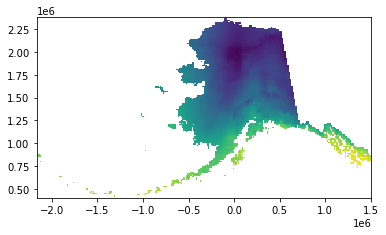

In [6]:
with rio.open(dst_fp) as src:
    show(src, interpolation="none")